# 1. Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

## Data Loading and Exploration

In [2]:
raw_data = pd.read_csv("customer_segmentation_data.csv", sep = ",", index_col = False)
raw_data.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


* Variable: minutes watched

    Data type: numerical
    
    Range: Integer

    Description: The number of minutes a student has watched since joining the program

* Variable: CLV

    Data type: numerical

    Range: Integer

    Description: The Customer Lifetime Value, or CLV, shows the total amount of revenue generated by that customer

* Variable: Region

    Data type: categorical

    Range: {0, 1, 2}

    Description: This is the geographical region where the student comes from.

    1. USA, Canada, United Kingdom, Australia
    1. Western Europe
    1. Rest of the World

* Variable: Channel

    Data type: categorical
    
    Range: {1, 2, 3, 4, 5, 6, 7, 8}

    Description: This is the channel through which the customer has learned about the 365 program

    1. Google
    1. Facebook
    1. YouTube
    1. LinkedIn
    1. Twitter
    1. Instagram
    1. Friend
    1. Other

In [3]:
data = raw_data.copy()

In [4]:
data_columns = data.columns
data_columns

Index(['minutes_watched', 'CLV', 'region', 'channel'], dtype='object')

In [5]:
data.region.unique()

array([2, 0, 1], dtype=int64)

In [6]:
data.channel.unique()

array([4, 1, 2, 3, 8, 6, 7, 5], dtype=int64)

In [7]:
data.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [8]:
data.isnull().sum()

minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64

We have **null values** on the minutes_watched column.

Most likely, these null values correspond to people who've entered the program, but have not seen any content.

having not seen any content is equivalent as value of 0, so it is appropriate to replace missing values with 0.

### Deal with missing values

In [9]:
# Fill the missing values with zeroes.
data['minutes_watched'] = data['minutes_watched'].fillna(0)

In [10]:
data.isnull().sum()

minutes_watched    0
CLV                0
region             0
channel            0
dtype: int64

In [11]:
data.describe()

,minutes_watched,CLV,region,channel
count,3834.000000,3834.000000,3834.000000,3834.000000
mean,1916.028169,118.383920,1.167188,3.870370
std,7303.052488,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,137.000000,62.580000,0.000000,2.000000
50%,480.500000,119.000000,2.000000,3.000000
75%,1464.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [12]:
data.dtypes

minutes_watched    float64
CLV                float64
region               int64
channel              int64
dtype: object

## Feature Engineering

### Create Dummy Variables

To perform a quantitative analysis of the groups, I created dummy variables for the region of countries and the survey answers. These are categorical answers, so having them as dummy variables makes sense.

In [13]:
data_regions = data["region"]

In [14]:
data_heard_from = data["channel"]

In [15]:
dummies_regions = pd.get_dummies(data_regions, prefix = "Region", prefix_sep = "_")
dummies_regions.head()

,Region_0,Region_1,Region_2
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,1,0


In [16]:
data = pd.concat([data, dummies_regions], axis = 1)
data.head()

,minutes_watched,CLV,region,channel,Region_0,Region_1,Region_2
0,3197.0,205.42,2,4,0,0,1
1,63.0,149.99,0,1,1,0,0
2,605.0,119.00,2,2,0,0,1
3,20.0,240.00,2,4,0,0,1
4,245.0,184.36,1,4,0,1,0


In [17]:
dummies_heard_from = pd.get_dummies(data_heard_from, prefix = "channel", prefix_sep = "_")
dummies_heard_from.head()

,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0


In [18]:
data = pd.concat([data, dummies_heard_from], axis = 1)
data.head()

,minutes_watched,CLV,region,channel,Region_0,Region_1,Region_2,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
0,3197.0,205.42,2,4,0,0,1,0,0,0,1,0,0,0,0
1,63.0,149.99,0,1,1,0,0,1,0,0,0,0,0,0,0
2,605.0,119.00,2,2,0,0,1,0,1,0,0,0,0,0,0
3,20.0,240.00,2,4,0,0,1,0,0,0,1,0,0,0,0
4,245.0,184.36,1,4,0,1,0,0,0,0,1,0,0,0,0


In [19]:
# drop the channel variable as it is non-numerical and we'll not be able to perform the segmentation
data = data.drop(["channel"], axis = 1)
data

,minutes_watched,CLV,region,Region_0,Region_1,Region_2,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
0,3197.0,205.42,2,0,0,1,0,0,0,1,0,0,0,0
1,63.0,149.99,0,1,0,0,1,0,0,0,0,0,0,0
2,605.0,119.00,2,0,0,1,0,1,0,0,0,0,0,0
3,20.0,240.00,2,0,0,1,0,0,0,1,0,0,0,0
4,245.0,184.36,1,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,1,0,0,0,0,1,0,0,0,0,0
3830,28.0,79.00,0,1,0,0,0,1,0,0,0,0,0,0
3831,57.0,36.00,2,0,0,1,0,1,0,0,0,0,0,0
3832,44.0,36.00,2,0,0,1,1,0,0,0,0,0,0,0


In [20]:
# rename the columns after adding the dummie variables
data = data.rename(columns = {'channel_1':'Google', 'channel_2':'Facebook', 'channel_3':'YouTube','channel_4':'LinkedIn', 
                              'channel_5':'Twitter', 'channel_6':'Instagram', 'channel_7':'Friend', 'channel_8':'Other',
                              'Region_0':'Anglo-Saxon', 'Region_1':'WE', 'Region_2':'World'})
data

,minutes_watched,CLV,region,Anglo-Saxon,WE,World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other
0,3197.0,205.42,2,0,0,1,0,0,0,1,0,0,0,0
1,63.0,149.99,0,1,0,0,1,0,0,0,0,0,0,0
2,605.0,119.00,2,0,0,1,0,1,0,0,0,0,0,0
3,20.0,240.00,2,0,0,1,0,0,0,1,0,0,0,0
4,245.0,184.36,1,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,1,0,0,0,0,1,0,0,0,0,0
3830,28.0,79.00,0,1,0,0,0,1,0,0,0,0,0,0
3831,57.0,36.00,2,0,0,1,0,1,0,0,0,0,0,0
3832,44.0,36.00,2,0,0,1,1,0,0,0,0,0,0,0


**Note!**

* Region_0 - **Anglo-Saxon** - USA, Canada, United Kingdom, Australia
* Region_1 - **WE** - Western Europe
* Region_2 - **World** - Rest of the world

## Data Visualization and Correlation Analysis

### Correlation Heatmap

In [21]:
data.iloc[:, 0:3].corr()

,minutes_watched,CLV,region
minutes_watched,1.000000,0.114153,0.040100
CLV,0.114153,1.000000,-0.273312
region,0.040100,-0.273312,1.000000


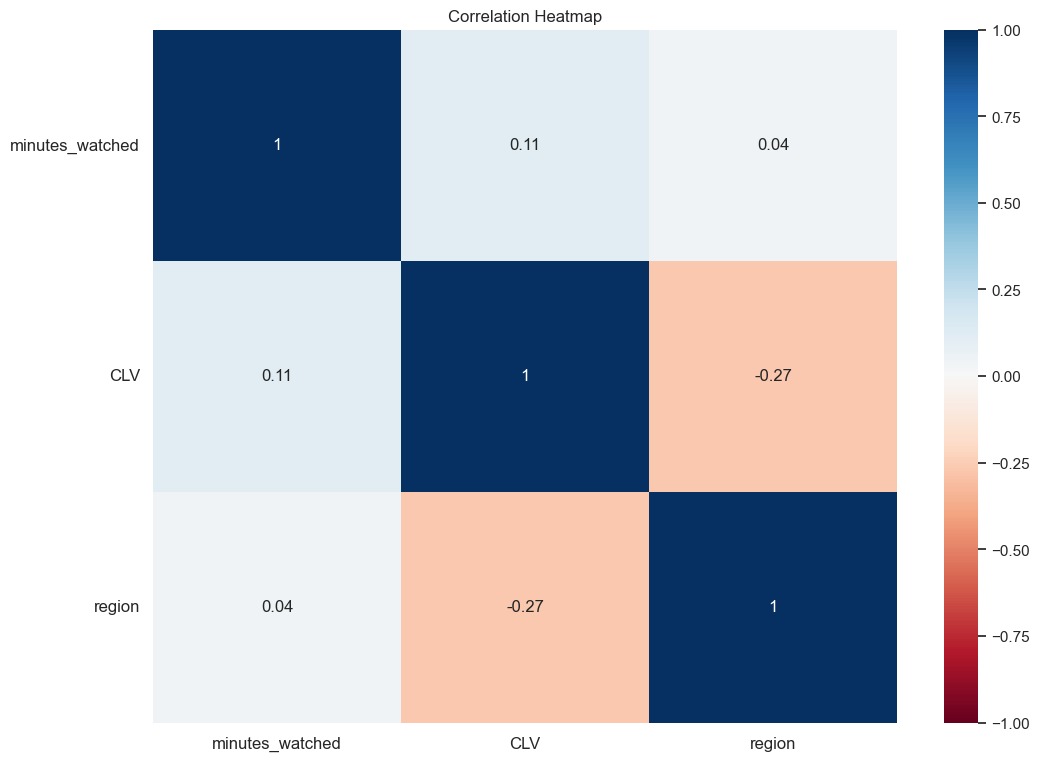

In [22]:
plt.figure(figsize = (12, 9))
axes = sns.heatmap(data.iloc[:, 0:3].corr(),
                   annot = True,
                   cmap = "RdBu",
                   vmin = -1,
                   vmax = 1)

plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(rotation = 0, fontsize = 12)

plt.title("Correlation Heatmap")
plt.savefig("corr.png")
plt.show()

This analysis does not reveal strong or positive correlations within the data. So, we must employ more sophisticated learning methods to understand the relationships within the data.

###  CLV vs Minutes watched

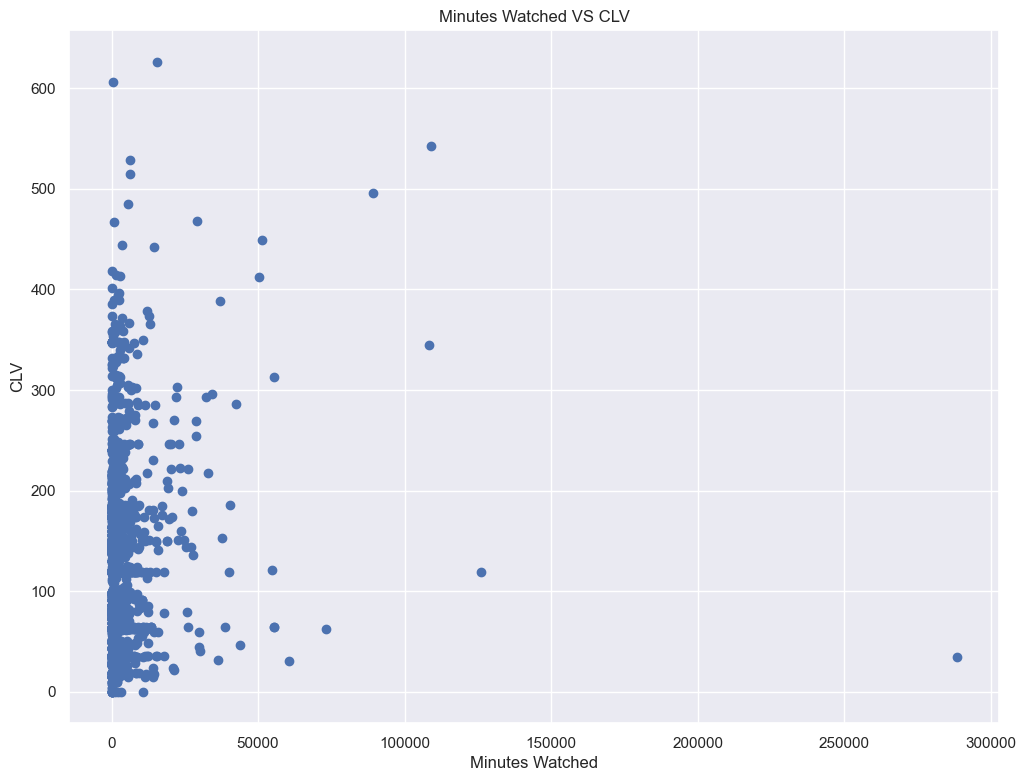

In [23]:
plt.figure(figsize = (12, 9))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1])
plt.xlabel("Minutes Watched")
plt.ylabel("CLV")
plt.title("Minutes Watched VS CLV")
plt.savefig("scatter.png")
plt.show()

By visualizing the minutes watched by the CLV, there’s little to be revealed. Apart from noticing a few outliers, we cannot conclude anything because the scale of the minutes watched vastly differs from that of the CLV. This leaves the chart looking cluttered.

A possible solution would be to remove the outliers or rescale the minutes watched to hours watched.

This scatter plot serves as an illustrative reminder that it is important to uniformly scale all features to ensure they hold equal weight during segmentation.

# 2. Model Implementation

## Standardize the variables

In [24]:
# Initializing a StandardScaler object to standardize the features.
scaler = StandardScaler()

scaler.fit(data)

data_scaled = scaler.transform(data)

In [25]:
data_scaled

array([[ 0.17542513,  1.23521866,  0.90235187, ..., -0.28552281,
        -0.37740094, -0.2849882 ],
       [-0.25376647,  0.44855443, -1.26464912, ..., -0.28552281,
        -0.37740094, -0.2849882 ],
       [-0.17954125,  0.00874342,  0.90235187, ..., -0.28552281,
        -0.37740094, -0.2849882 ],
       ...,
       [-0.25458815, -1.16919507,  0.90235187, ..., -0.28552281,
        -0.37740094, -0.2849882 ],
       [-0.25636846, -1.16919507,  0.90235187, ..., -0.28552281,
        -0.37740094, -0.2849882 ],
       [-0.26239413, -0.55893778, -1.26464912, ..., -0.28552281,
        -0.37740094, -0.2849882 ]])

## Hierarchical Clustering

In [26]:
# Performing hierarchical clustering on the standardized data using the 'ward' method.
# The 'ward' method minimizes the sum of squared differences within all clusters.
hier_clust = linkage(data_scaled, method = 'ward')

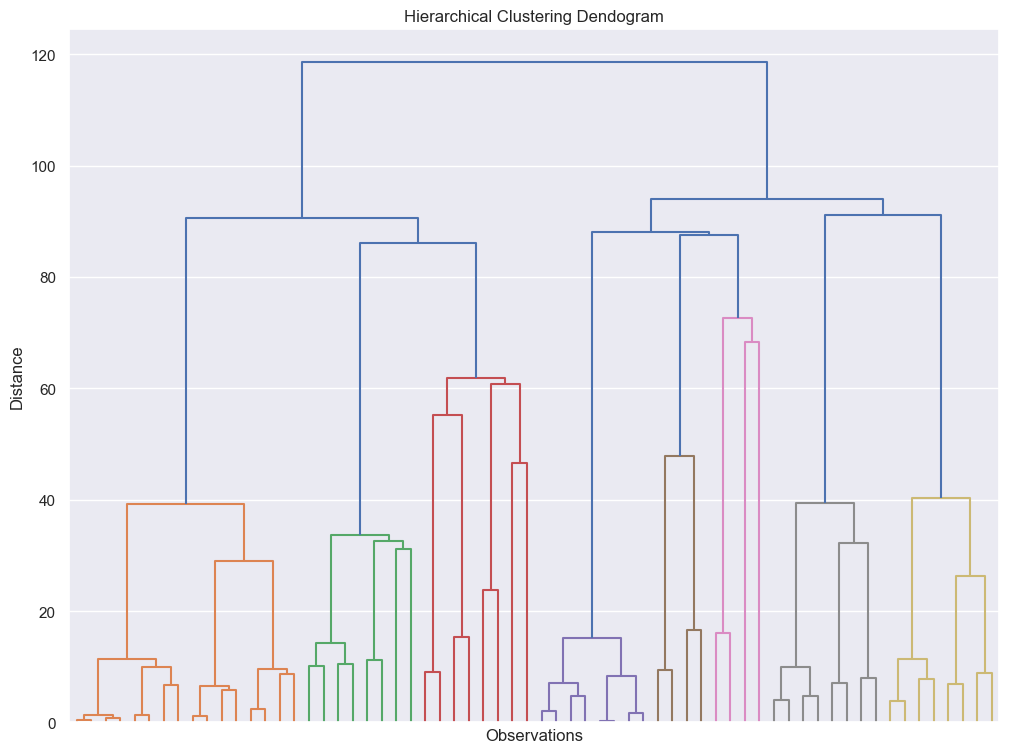

In [27]:
plt.figure(figsize = (12, 9))

plt.title("Hierarchical Clustering Dendogram")

plt.xlabel("Observations")

plt.ylabel("Distance")

dendrogram(hier_clust,
           truncate_mode = "level",
           p = 5,
           show_leaf_counts = False,
           no_labels = True)

plt.savefig("hierarchical.png")

plt.show()

## K-Means Segmentation

### WCSS

In [28]:
# Initializing an empty list to store the Within-Cluster-Sum-of-Squares (WCSS) for different cluster numbers.
wcss = []
cl_num = 11

# Looping through numbers 1 to 10 to evaluate the optimal number of clusters for k-means clustering.
for i in range(1, cl_num):
    kmeans = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans.fit(data_scaled)
    wcss_iter =  kmeans.inertia_
    wcss.append(wcss_iter)

wcss

C:\Users\acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\acer\anaconda3\lib\site-packages\sklearn\cluster\_k

[53676.0,
 42974.36963592752,
 37750.24569660349,
 34003.790655368175,
 32033.41778205009,
 29339.446904209413,
 25571.40054707215,
 22653.65834642346,
 19616.934459289427,
 17755.258233834575]

### Elbow method

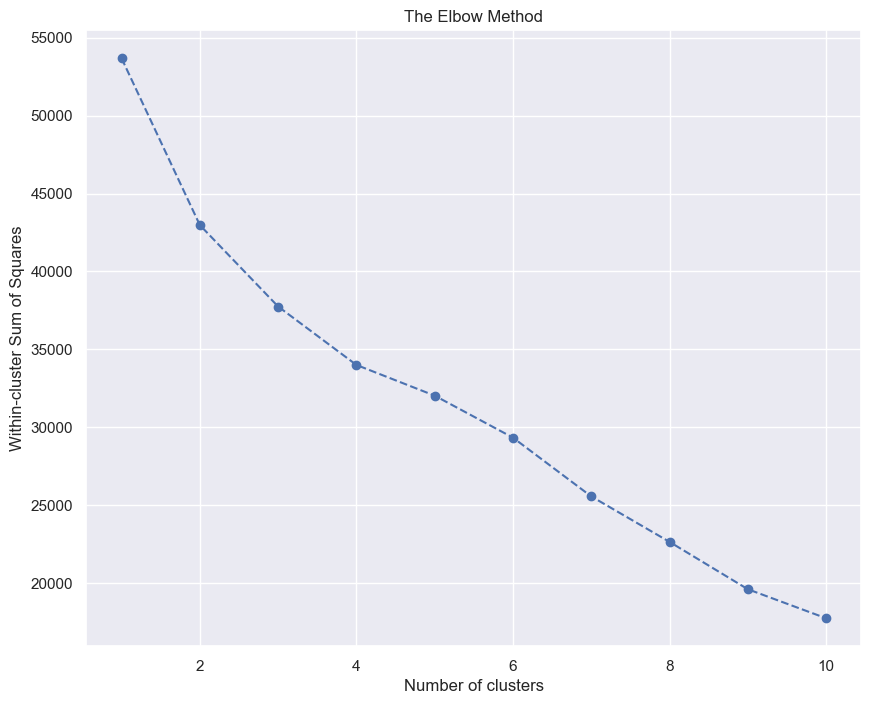

In [29]:
number_clusters = range(1,cl_num)

plt.figure(figsize = (10, 8))

plt.plot(number_clusters, wcss, marker = "o", linestyle = "--")
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')

plt.savefig("line_chart.png")

plt.show()

These results **doesn't show clear result** indicating which number of clusters is best to use as with hierarchical clustering.

Here because I had **preliminary idea** of the number of clusters given from the Hierarchical Clustering, I decided to **continue with using 8 clusters** for K-means clustering

**Reasons** why k-means and hierarchical clustering might suggest different number of clusters:
1. **Different methodologies.**
1. **Initial setup sensitivity:** K-means is highly sensitive to initial starting conditions. Different runs give different results. Hierarchical clustering is deterministic and will always provide the same result with the same data.
1. **Cluster shape:** K-means works best with spherical and evenly sized clusters. Hierarchical clustering does not have these assumptions.

### K-means with 8 Clusters as suggested by the hierarchical clustering

In [30]:
kmeans = KMeans(n_clusters = 8, init = "k-means++", random_state = 42)

In [31]:
kmeans.fit(data_scaled)

C:\Users\acer\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=42)

# 3. Model Evaluation and Results

In [32]:
# Creating a copy to avoid modyfying the original dataframe
data_kmeans = data.copy()

# Add the clustering prediction generated by k-means to a new column
data_kmeans["cluster_pred"] = kmeans.predict(data_scaled)
data_kmeans.set_index(["cluster_pred"])

,minutes_watched,CLV,region,Anglo-Saxon,WE,World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other
cluster_pred,,,,,,,,,,,,,,
1,3197.0,205.42,2,0,0,1,0,0,0,1,0,0,0,0
4,63.0,149.99,0,1,0,0,1,0,0,0,0,0,0,0
7,605.0,119.00,2,0,0,1,0,1,0,0,0,0,0,0
1,20.0,240.00,2,0,0,1,0,0,0,1,0,0,0,0
5,245.0,184.36,1,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,11.0,79.00,0,1,0,0,0,0,1,0,0,0,0,0
7,28.0,79.00,0,1,0,0,0,1,0,0,0,0,0,0
7,57.0,36.00,2,0,0,1,0,1,0,0,0,0,0,0


In [33]:
# Grouping the dataframe by the 'Segment' column and calculating the mean for each segment.
# This provides a profile for each cluster based on the mean values of the original features.
data_kmeans_analysis = data_kmeans.groupby(["cluster_pred"]).mean()

data_kmeans_analysis

,minutes_watched,CLV,region,Anglo-Saxon,WE,World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other
cluster_pred,,,,,,,,,,,,,,
0,1299.332180,115.180277,1.186851,0.311419,0.190311,0.498270,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000
1,1801.265985,91.118312,2.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000
2,2018.969340,109.117382,1.419811,0.290094,0.000000,0.709906,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000
3,2326.887114,103.938839,2.000000,0.000000,0.000000,1.000000,0.349308,0.0,0.544196,0.000000,0.0,0.0,0.000000,0.106496
4,1539.152607,136.329469,0.000000,1.000000,0.000000,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.000000,0.140284
5,1874.747312,157.922581,1.000000,0.000000,1.000000,0.000000,0.217742,0.0,0.341398,0.188172,0.0,0.0,0.145161,0.107527
6,985.327586,93.151552,1.603448,0.172414,0.051724,0.775862,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000
7,2767.643791,108.260359,1.323529,0.287582,0.101307,0.611111,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [34]:
# Counting the number of observations in each segment.
# 'minutes_watched' is used arbitrarily to count, as it exists in each segment.
data_kmeans_analysis["N Obs"] = data_kmeans[["cluster_pred", "minutes_watched"]].groupby(["cluster_pred"]).count()
data_kmeans_analysis

,minutes_watched,CLV,region,Anglo-Saxon,WE,World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,N Obs
cluster_pred,,,,,,,,,,,,,,,
0,1299.332180,115.180277,1.186851,0.311419,0.190311,0.498270,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,289
1,1801.265985,91.118312,2.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,391
2,2018.969340,109.117382,1.419811,0.290094,0.000000,0.709906,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,424
3,2326.887114,103.938839,2.000000,0.000000,0.000000,1.000000,0.349308,0.0,0.544196,0.000000,0.0,0.0,0.000000,0.106496,939
4,1539.152607,136.329469,0.000000,1.000000,0.000000,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.000000,0.140284,1055
5,1874.747312,157.922581,1.000000,0.000000,1.000000,0.000000,0.217742,0.0,0.341398,0.188172,0.0,0.0,0.145161,0.107527,372
6,985.327586,93.151552,1.603448,0.172414,0.051724,0.775862,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,58
7,2767.643791,108.260359,1.323529,0.287582,0.101307,0.611111,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,306


In [35]:
# Calculating the proportion of observations in each segment.
# This is done by dividing the number of observations in a segment by the total number of observations.
data_kmeans_analysis["Prop Obs"] = data_kmeans_analysis["N Obs"] / data_kmeans_analysis["N Obs"].sum()
data_kmeans_analysis

,minutes_watched,CLV,region,Anglo-Saxon,WE,World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,N Obs,Prop Obs
cluster_pred,,,,,,,,,,,,,,,,
0,1299.332180,115.180277,1.186851,0.311419,0.190311,0.498270,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,289,0.075378
1,1801.265985,91.118312,2.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,391,0.101982
2,2018.969340,109.117382,1.419811,0.290094,0.000000,0.709906,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,424,0.110589
3,2326.887114,103.938839,2.000000,0.000000,0.000000,1.000000,0.349308,0.0,0.544196,0.000000,0.0,0.0,0.000000,0.106496,939,0.244914
4,1539.152607,136.329469,0.000000,1.000000,0.000000,0.000000,0.248341,0.0,0.432227,0.179147,0.0,0.0,0.000000,0.140284,1055,0.275170
5,1874.747312,157.922581,1.000000,0.000000,1.000000,0.000000,0.217742,0.0,0.341398,0.188172,0.0,0.0,0.145161,0.107527,372,0.097027
6,985.327586,93.151552,1.603448,0.172414,0.051724,0.775862,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,58,0.015128
7,2767.643791,108.260359,1.323529,0.287582,0.101307,0.611111,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,306,0.079812


In [36]:
# Rounding the dataframe values to 2 decimal places for cleaner presentation.
data_kmeans_analysis = data_kmeans_analysis.round(2)

In [37]:
# Renaming the index labels (which are segment numbers) with more descriptive names.
# This provides a more interpretable profile for each cluster.
data_kmeans_analysis = data_kmeans_analysis.rename({0:'Instagram Explorers',
                                                    1:'LinkedIn Networkers',
                                                    2:'Friends\' Influence',
                                                    3:'Google-YouTube Mix',
                                                    4:'Anglo-Saxon Multi-Channel', 
                                                    5:'European Multi-Channel',
                                                    6:'Twitter Devotees',
                                                    7:'Facebook Followers',
                                                   })
data_kmeans_analysis.head()

,minutes_watched,CLV,region,Anglo-Saxon,WE,World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,N Obs,Prop Obs
cluster_pred,,,,,,,,,,,,,,,,
Instagram Explorers,1299.33,115.18,1.19,0.31,0.19,0.50,0.00,0.0,0.00,0.00,0.0,1.0,0.0,0.00,289,0.08
LinkedIn Networkers,1801.27,91.12,2.00,0.00,0.00,1.00,0.00,0.0,0.00,1.00,0.0,0.0,0.0,0.00,391,0.10
Friends' Influence,2018.97,109.12,1.42,0.29,0.00,0.71,0.00,0.0,0.00,0.00,0.0,0.0,1.0,0.00,424,0.11
Google-YouTube Mix,2326.89,103.94,2.00,0.00,0.00,1.00,0.35,0.0,0.54,0.00,0.0,0.0,0.0,0.11,939,0.24
Anglo-Saxon Multi-Channel,1539.15,136.33,0.00,1.00,0.00,0.00,0.25,0.0,0.43,0.18,0.0,0.0,0.0,0.14,1055,0.28


In [38]:
# Mapping the cluster numbers (Segment) to more human-readable labels using a dictionary.
# This helps in interpreting the clusters in plots and other visualizations.
data_kmeans["Labels"] = data_kmeans["cluster_pred"].map({0:'Instagram Explorers',
                                                         1:'LinkedIn Networkers',
                                                         2:'Friends\' Influence',
                                                         3:'Google-YouTube Mix',
                                                         4:'Anglo-Saxon Multi-Channel', 
                                                         5:'European Multi-Channel',
                                                         6:'Twitter Devotees',
                                                         7:'Facebook Followers', 
                                                        })
data_kmeans.head()

,minutes_watched,CLV,region,Anglo-Saxon,WE,World,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,cluster_pred,Labels
0,3197.0,205.42,2,0,0,1,0,0,0,1,0,0,0,0,1,LinkedIn Networkers
1,63.0,149.99,0,1,0,0,1,0,0,0,0,0,0,0,4,Anglo-Saxon Multi-Channel
2,605.0,119.00,2,0,0,1,0,1,0,0,0,0,0,0,7,Facebook Followers
3,20.0,240.00,2,0,0,1,0,0,0,1,0,0,0,0,1,LinkedIn Networkers
4,245.0,184.36,1,0,1,0,0,0,0,1,0,0,0,0,5,European Multi-Channel


In [39]:
data_kmeans_analysis.to_excel("analysis.xlsx")

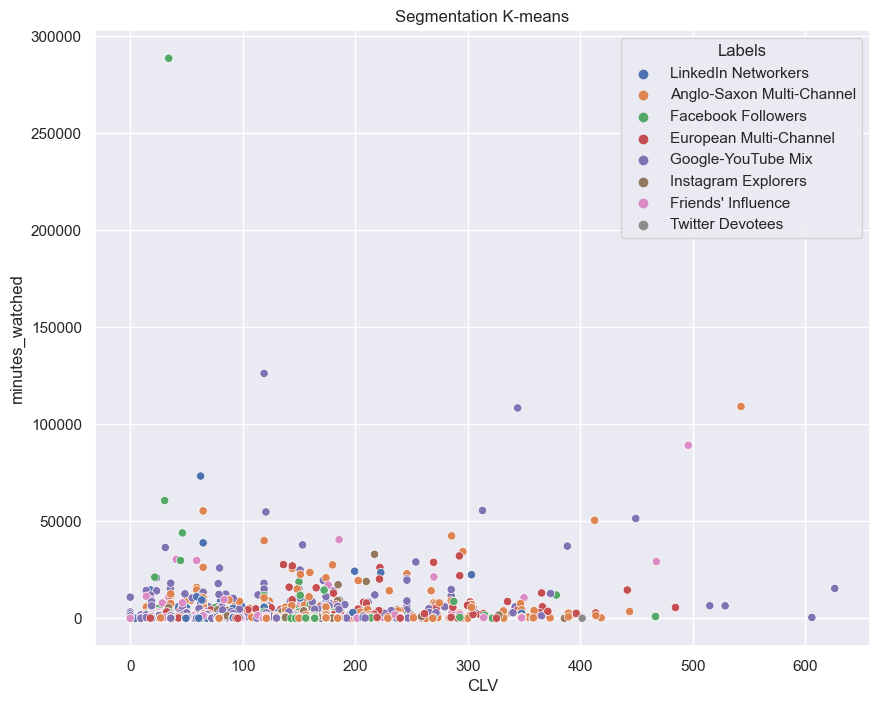

In [40]:
plt.figure(figsize = (10, 8))

sns.scatterplot(x = data_kmeans["CLV"], y = data_kmeans["minutes_watched"], hue = data_kmeans["Labels"])

plt.title("Segmentation K-means")

plt.savefig("segmentation_k_means.png")

plt.show()

In [41]:
# Plot only certain label
data_kmeans_sliced = data_kmeans.copy()
data_kmeans_sliced = data_kmeans.loc[data_kmeans["Labels"].isin(["Instagram Explorers", "Anglo-Saxon Multi-Channel"])]

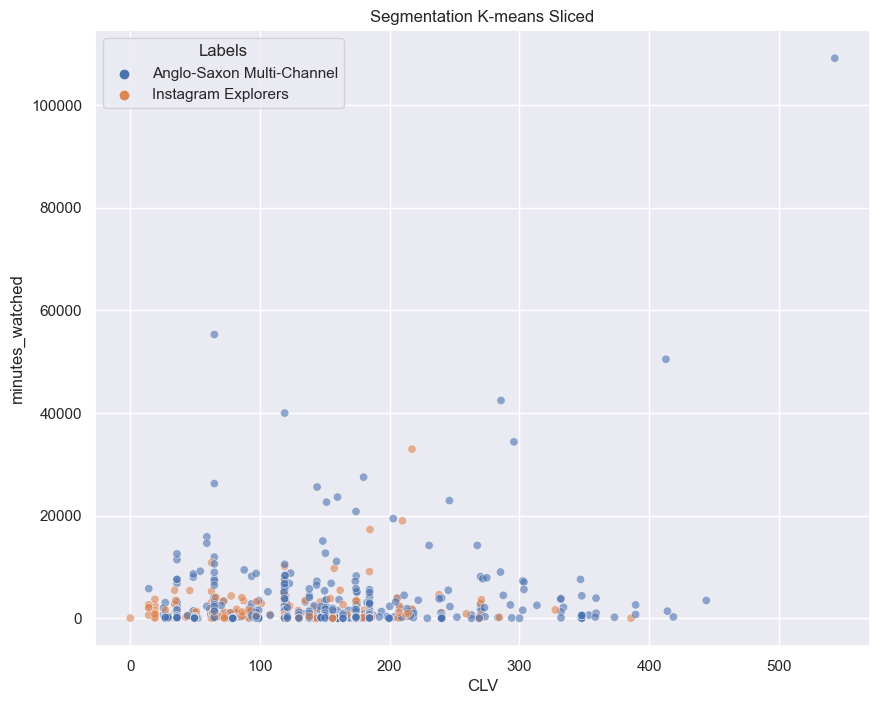

In [42]:
plt.figure(figsize = (10, 8))

sns.scatterplot(x = data_kmeans_sliced["CLV"],
                y = data_kmeans_sliced["minutes_watched"],
                hue = data_kmeans_sliced["Labels"],
                alpha = 0.6)

plt.title("Segmentation K-means Sliced")

plt.savefig("segmentation_k_means_sliced.png")

plt.show()

Based on that information, we can formulate the following clusters.
* Segment 0 – **Instagram Explorers** (289 Observations): These customers are from all regions, with a slightly larger group from the rest of the world. They discovered the platform through Instagram and have a relatively **moderate level of engagement and expenditure**.
* Segment 1 – **LinkedIn Networkers** (391 Observations): This segment consists entirely of customers from the rest of the world who have heard about your platform via LinkedIn. They have a **high level of engagement but slightly lower spending**.
* Segment 2 – **Friends' Influence** (424 Observations): This group primarily comprises customers from the rest of the world who discovered the platform through friends. They have **high engagement and moderate spending**.
* Segment 3 – **Google-YouTube Mix** (939 Observations): These customers from the rest of the world discovered the platform via a mix of Google and YouTube. They have very **high engagement and moderate spending**.
* Segment 4 – **Anglo-Saxon Multi-Channel** (1055 Observations): This segment includes customers from the US, Canada, The UK, and Australia who discovered the platform through a mix of Google, YouTube, and LinkedIn. They have **high engagement and higher-than-average spending**.
* Segment 5 – **European Multi-Channel** (372 Observations): These customers are from Western Europe and heard about the platform from various sources, including Google, YouTube, LinkedIn, and friends. They have **high engagement and the highest spending level**.
* Segment 6 – **Twitter Devotees** (58 Observations): This small group of customers discovered the platform via Twitter. They’re from all regions, with a majority from the rest of the world. They have the **lowest engagement but moderate spending**.
* Segment 7 – **Facebook Followers** (306 Observations): This group mainly heard about the platform from Facebook. They are from all regions but predominantly from the rest of the world. They have the **highest level of engagement and moderate spending**.

# 4. Data Interpretation

## Interpretation and Reporting

Finally, I am going to interpret the customer segments from a marketing perspective. We should discuss these results with the marketing team and help employ a viable **marketing strategy**.

We should go through the different segments and analyze the channels through which customers visited the platform and their regions. 

These are the **questions** we try to answer with our analysis:
* Are there segments that attract engaged students with high Customer Lifetime Value (CLV)?
* From which channels do these segments originate, and which regions do they come from?

**Note:** Assume that the current marketing spend is **equally** allocated across all customer outreach methods and regions.

Based on these insights, the marketing team will be able to devise strategies for:

* **New Customer Outreach Method:** Identify the best channels for approaching each region.
* **Channels Performance Analysis:** Identify underperforming channels.

### Segments: 
1. **Twitter Devotees:** This smallest segment, with only 58 observations, shows that efforts on Twitter are largely ineffective. We recommend minimizing spending and resources on Twitter due to its recent instability and **the marketing team should consider early adoption of new platforms like Threads.**

1. **Facebook Users:** Although not the largest segment (around 8% of customers) and having lower average spending, Facebook users are highly dedicated to learning, with an impressive average watch time of over 2,700 minutes. This segment is diverse, with nearly a third from the US, Canada, or the UK, and over 60% from the rest of the world. **Further analysis on engagement could reveal why this group is so motivated to study.**

    **In terms of countries,** it’s a mixed bag, with a little under a third from the US, Canada, or United Kingdom and over 60% from the rest of the world. It would be worth exploring how these students interact with the platform and why their group is more motivated to study. But this would be the focus of a different analysis on engagement.

### Performance by region:
1. **Anglo-Saxon Region:** This region shows the **best performance**, as **the largest customer segment** mainly comes from the USA, Canada, the UK, and Australia. 
1. **The Google-YouTube mix** is particularly effective being **the second largest segment**, attracting over 900 customers.
1. **Western Europe:** This region has the **fewest customers** despite our assumption of having equal marketing spending across regions. However, it has the highest **Customer Lifetime Value (CLV)**, indicating that improving marketing efforts here is essential.
Rest of the World: This is the second-largest area, with LinkedIn being the most successful channel, followed by Facebook.

### CLV: 
1. **Anglo-Saxon and European Multichannel:** These regions have the highest-paying clusters. Effective channels include Google, YouTube, and LinkedIn. **Increasing spending on these channels in these regions is recommended due to their high CLV.**
1. **Other Regions:** LinkedIn should be the primary channel for attracting customers, followed by Facebook, due to its excellent reach and popularity.

**Based on this analysis, focus on successful channels for each region, increase spending where CLV is highest, and reconsider underperforming platforms to optimize marketing efforts.**